# Collimator Detection

This method detects the presence of a collimator be looking at changes in row and column intensities in the image. The two largest gradient changes are taken (the largest second derivative peaks) in the rows and columns. These are used to draw a rectangle isolating the region of interest.

In [3]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
import peakutils
from PIL import Image

## Load in image

In [4]:
img = Image.open('/media/sf_TestImageDataBase/rectangle/jpeg_converted/NeckofFemur.jpg')

In [5]:
#rotate by 22.5 degrees each
img = img.rotate(0)
img.save('rotated.jpg')

In [22]:
img = cv.imread('rotated.jpg')

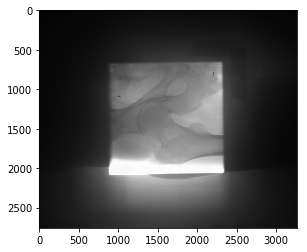

In [25]:
plt.imshow(img)
plt.show()

In [26]:
height,width,depth = img.shape

# Is the image collimated?

In [85]:
def dark(image):
    height,width,depth = image.shape
    num_dark_left = np.count_nonzero(image[:,0:width/10] < [20])/3
    num_dark_right = np.count_nonzero(image[:,-width/10:width] < [20])/3
    num_dark_top = np.count_nonzero(image[0:height/10,:] < [20])/3
    num_dark_bottom = np.count_nonzero(image[-height/10:height,:] < [20])/3
    num_dark = num_dark_left+num_dark_right+num_dark_bottom+num_dark_top
    
    total = (width/10)*height*2 + (height/10)*width*2
    
    return (float(num_dark)/float(total))

In [86]:
cp = np.copy(img)
cp[cp<100] = 1
cp[cp>150] = 255

In [87]:
ratio = dark(cp)
ratio

1.00167598138392

In [88]:
if ratio > 0.6:
    print ('image is collimated')
else:
    print ('image is not collimated')

image is collimated


## Average over intensities

### Iterate over width

In [67]:
tot_avg_width = np.array([])
for i in range(width):
    avg = np.average(img[:,i])
    
    tot_avg_width = np.append(tot_avg_width,avg)
    
x_width = np.arange(0,width)

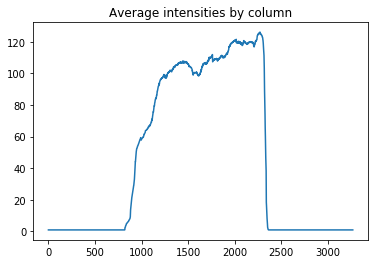

In [68]:
plt.plot(x_width,tot_avg_width)
plt.title('Average intensities by column')
plt.show()

Smooth and take the second derivative

In [69]:
y_width = savgol_filter(tot_avg_width, window_length=51, polyorder=2, deriv=2) 

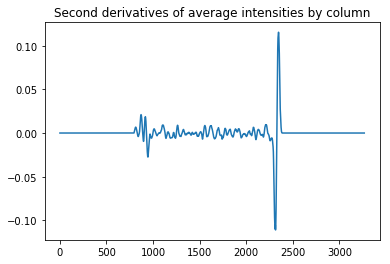

In [70]:
plt.plot(x_width,y_width)
plt.title('Second derivatives of average intensities by column')
plt.show()

### Iterate over height

In [71]:
tot_avg_height = np.array([])
for i in range(height):
    avger = np.average(img[i,:])
    
    tot_avg_height = np.append(tot_avg_height,avger)
    
x_height = np.arange(0,height) 

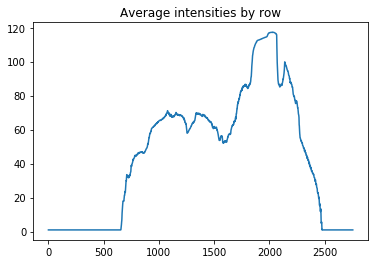

In [72]:
plt.plot(x_height,tot_avg_height)
plt.title('Average intensities by row')
plt.show()

Smooth and take second derivative

In [73]:
y_height = savgol_filter(tot_avg_height, window_length=51, polyorder=2, deriv=2) 

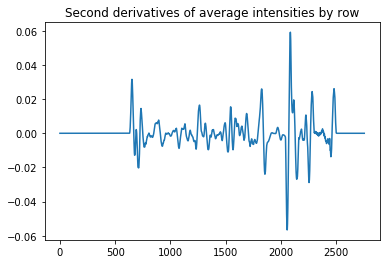

In [74]:
plt.plot(x_height,y_height)
plt.title('Second derivatives of average intensities by row')
plt.show()

# Measuring the noise

In [75]:
def deviation(data):
    n = len(data)
    avg = np.average(data)
    sigma = np.power(np.sum(np.power(data-avg,2))/(n-1),0.5)
    
    return sigma
    

In [76]:
deviation(y_height)

0.00897685629932154

# If Collimated -> detect

## Peak detection

In [77]:
peakfind_width = peakutils.indexes(y_width, thres=0.1, min_dist=500)
peakfind_height = peakutils.indexes(y_height, thres=0.1, min_dist=500)

In [78]:
peaks_width = y_width[peakfind_width]
peaks_height = y_height[peakfind_height]
print (peaks_width)

[0.02108055 0.00858343 0.11546826]


In [79]:
sorted_width = np.argsort(peaks_width)
two_max_width = sorted_width[::-1][:2]

sorted_height = np.argsort(peaks_height)
two_max_height = sorted_height[::-1][:2]
print (peakfind_width[two_max_width])

[2347  871]


In [80]:
line3 = np.linspace(peakfind_width[two_max_width[0]],peakfind_width[two_max_width[0]],height)
line4 = np.linspace(peakfind_width[two_max_width[1]],peakfind_width[two_max_width[1]],height)

x2 = np.linspace(0,height,height)

line1 = np.linspace(peakfind_height[two_max_height[0]],peakfind_height[two_max_height[0]],width)
line2 = np.linspace(peakfind_height[two_max_height[1]],peakfind_height[two_max_height[1]],width)

x1 = np.linspace(0,width,width)

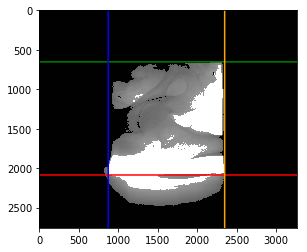

In [81]:
plt.plot(x1,line1, color = 'red')
plt.plot(x1,line2, color = 'green')
plt.plot(line3,x2, color = 'orange')
plt.plot(line4,x2, color = 'blue')
plt.imshow(img)
plt.show()

## Crop Image

In [82]:
tl = [int(line4[0]),int(line1[0])]
tr = [int(line3[0]),int(line1[0])]
bl = [int(line4[0]),int(line2[0])]
br = [int(line3[0]),int(line2[0])]

x_corners = np.array([int(line4[0]),int(line3[0])])
y_corners = np.array([int(line2[0]),int(line1[1])])

In [83]:
crop = img[np.min(y_corners)+50:np.max(y_corners)-50,np.min(x_corners)+50:np.max(x_corners)-50]

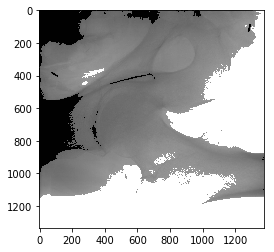

In [84]:
plt.imshow(crop)
plt.show()